# Analysis of the results

In [1]:
import sys
sys.path.append("..")

from analysis.analysis_utils import extract_all_info_from_hdf5, get_phenotype_table_from_parameters
from analysis.dataset import Dataset
from analysis.link_measure import compute_mean_xhis
from plot.dataset_plot import plot_hist_by_phenotype
from plot.plot import plot_xhi_by_phenotype
import matplotlib.pyplot as plt
import numpy as np

### Extracting all information from file

In [2]:
filepath = r"../out/E3O2P21R12T17_S75_T0.6_M1000_N10000000/E3O2P21R12T17_S75_T0.6_M1000_N10000000.h5"
adj_matrices, parameters = extract_all_info_from_hdf5(filepath)
niter = parameters["Number of interaction"]
phenotype_table = get_phenotype_table_from_parameters(parameters)

In [3]:
local_dt = Dataset('local')
local_dt.init_with_matrices(adj_matrices, parameters, niter)

### Analysis per phenotype

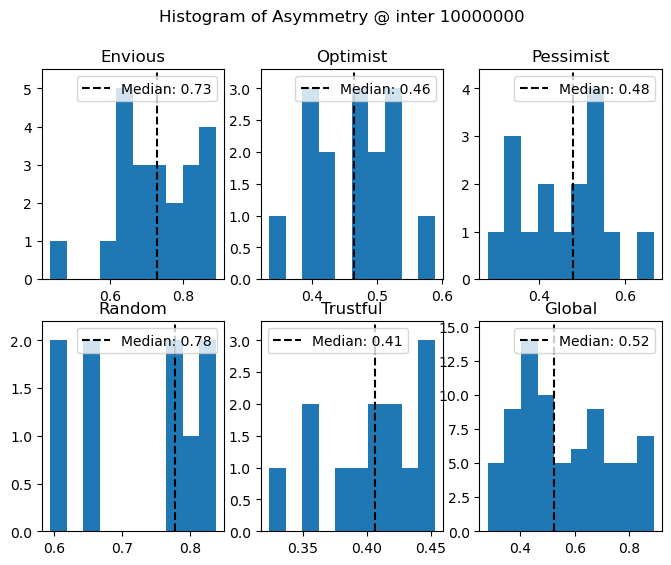

In [4]:
plot_hist_by_phenotype(local_dt, "Asymmetry")
plt.show()

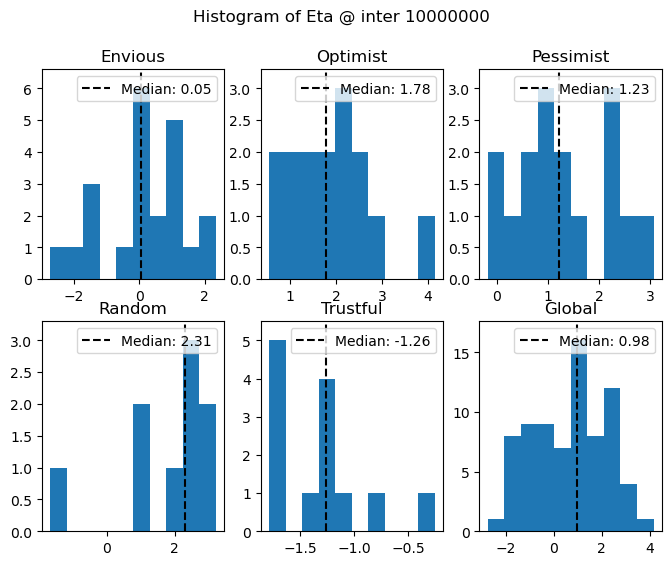

In [5]:
plot_hist_by_phenotype(local_dt, 'Eta')
plt.show()

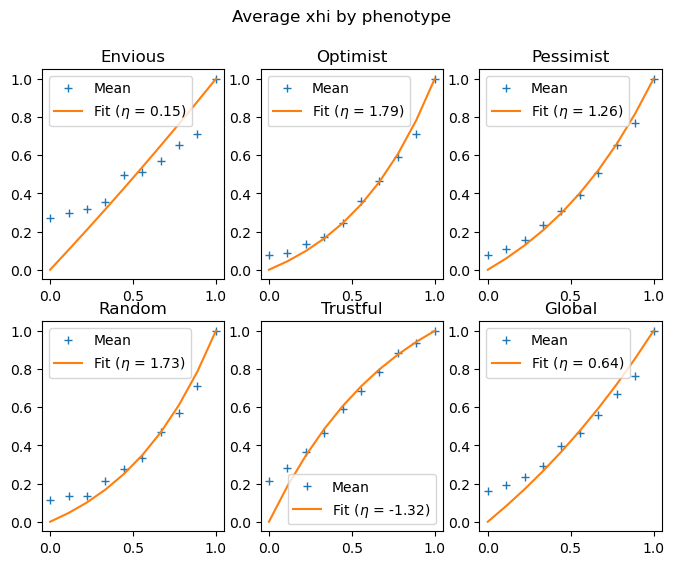

In [6]:
xhis = compute_mean_xhis(adj_matrices["peTotal"], parameters["Trust threshold"], phenotype_table)
plot_xhi_by_phenotype(xhis)
plt.show()

### Per game analysis

In [7]:
game_signature = "PD"

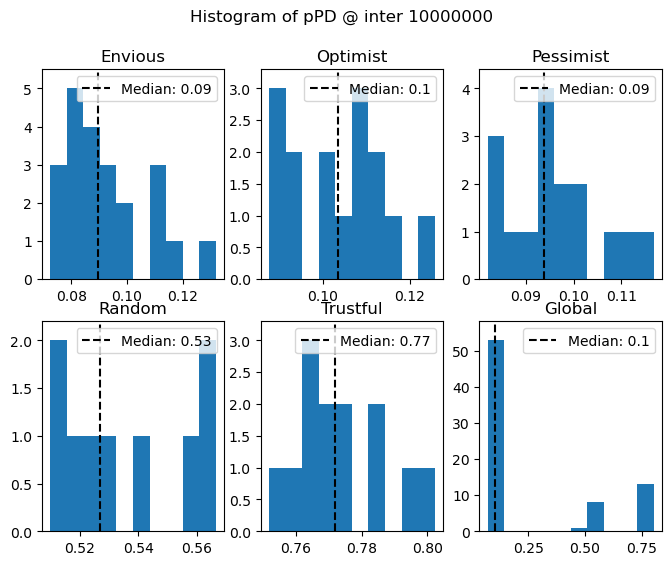

In [8]:
plot_hist_by_phenotype(local_dt, "p" + game_signature)
plt.show()

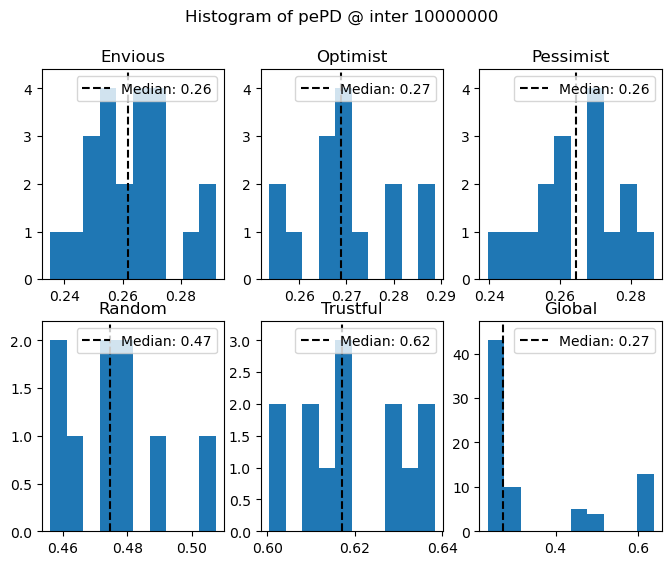

In [9]:
plot_hist_by_phenotype(local_dt, "pe" + game_signature)
plt.show()

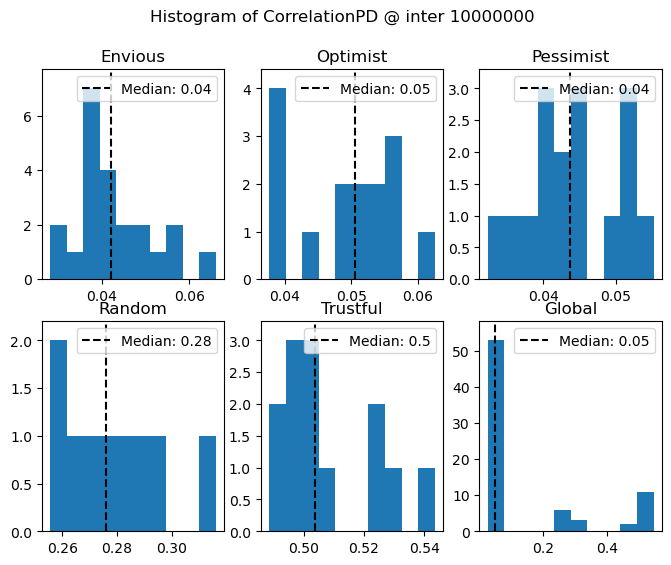

In [10]:
plot_hist_by_phenotype(local_dt, "Correlation" + game_signature)
plt.show()